# Evaluating Laplacian score for feature selection

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/decarpentierg/laplacian-score-4-time-series/blob/main/doc/evaluate_laplacian_score.ipynb)

**Authors:** Gonzague De Carpentier, Jérémie Dentan

The goal of this notebook is to conduct some experiments to evaluate the Laplacian score for feature selection as introduced by [1] fo feature selection. Our experiments focus on **feature selection for classification of times series**.

**Some details about the comparison:**
- We use three time serie datasets: [2], [3], and [4]. Those datasets have various length (from TODO to TODO), number of sample (from TODO to TODO) and number of classes (TODO).
- The features are extracted from the time series using library TSFEL [5]
- We compare the laplacian score with two other feature selection techniques:
    - Feature selection using a threshold on the variance
    - Feature selection using the F-value of ANOVA [6] 
- For the comparison of the classification performances, we use scikit-learn SVC classifier with default parameters


**References:**
- [1] : *Laplacian Score for feature selection*, Xiaofei He,  Deng Cai, Partha Niyogi. 2005. In *Advances in Neural Information Processing Systems*.
- [2] : Jason Lines, A. Bagnall, https://timeseriesclassification.com/description.php?Dataset=SmallKitchenAppliances
- [3] : https://timeseriesclassification.com/description.php?Dataset=DiatomSizeReduction
- [4] : M. Guillame-Bert, https://timeseriesclassification.com/description.php?Dataset=PigAirwayPressure
- [5] : Time Series Feature Extraction Library, https://tsfel.readthedocs.io 
- [6] : *The Analysis of Variance*, Henry scheffé. 1999. *John Wiley & Sons*

## Set up

You should run this notebook with `Python 3.9`. Moreover, this notebook is supposed to work with the code of repository [https://github.com/decarpentierg/laplacian-score-4-time-series](https://github.com/decarpentierg/laplacian-score-4-time-series), having the dependencies in `requirements.txt` installed and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line after the verbose should be a path to the root of the repository:
- If you are using this notebook directly from the repository, please set `CLONE_REPO=False` 
- If you are using this notebook as a standalone, please set `CLONE_REPO=True`

In [1]:
CLONE_REPO = False

In [2]:
from pathlib import Path
import os

REPO_NAME = 'laplacian-score-4-time-series'
REQUIREMENTS = 'requirements.txt'

# If all of this already have been done
if Path(os.getcwd()).name == REPO_NAME and Path('requirements.txt').exists():
    print('We are already at the root of the repo!')
    CLONE_REPO = False

# If we need to clone the repo but it's already here
if CLONE_REPO and Path(REPO_NAME).exists():
    print("The repository already exists!")
    CLONE_REPO = False
    os.chdir(REPO_NAME)
    assert Path(REQUIREMENTS).exists(), "There exists an incomplete version of the repository, please delete it and try again"

# If we need to clone the repo and it isn't here
os.environ['CLONE_REPO'] = str(CLONE_REPO)
!if [ "$CLONE_REPO" = "True" ]; then git clone https://github.com/decarpentierg/laplacian-score-4-time-series; fi
if CLONE_REPO:
    os.chdir(REPO_NAME)
    CLONE_REPO = False

# If the notebook is already in the repo, we simply need to move to the root
if not CLONE_REPO:
    while not (Path('requirements.txt')).exists():
        os.chdir('..')

# Installing dependencies, setting PYTHONPATH
print('This should be the root of the repo:')
!pwd
%pip install -r requirements.txt --quiet
!export PYTHONPATH=$(pwd)
print("All dependencies have been installed, you're ready to go!")

This should be the root of the repo:
/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/02-TimeSeries/laplacian-score-4-time-series
Note: you may need to restart the kernel to use updated packages.
All dependencies have been installed, you're ready to go!


In [3]:
import collections

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm

from src.utils.logs import logger
from src.utils.constants import *
from src.experiments.datasets import Dataset
from src.experiments import laplacian_score
from src.experiments.gridsearch import VarianceSelection
from src.experiments.classifiers import get_svc_accuracy

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

        5532ms INFO  [datasets.py] Initiating dataset Earthquakes
        5534ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Earthquakes
        5536ms INFO  [datasets.py] Initiating dataset Wafer
        5537ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
        5539ms INFO  [datasets.py] Initiating dataset WormsTwoClass
        5539ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass


## Influence of the parameter sigma

First, let's have a look at the influence of the parameter `sigma` for the performances of the Laplacian score for feature selection. For this demonstration, we will use the `SmallKitchenAppliances` [2] dataset. The following object is of type `src.experiments.datasets.Dataset`, and have some attributes that are cached on the disk: the features as extracted by TSFEL, the distance matrix with respect to the DTW distance, the distance matrix with respect to the euclidian distance, etc. In particular, the computation of the distance matrix for DTW is pretty long, about 30min for this dataset, but the repository stored a precomputed version of this matrix.

In [4]:
dataset = Dataset(WAFER)
dtw_matrix = dataset.dtw_distance_matrix

print(f'Shape of the features: (n_feat, n_sample)={dataset.features.shape}')
print(f'Shape of the DTW dist matrix: (n_sample, n_sample)={dtw_matrix.shape})')
print(f'Mean value of the DTW distance matrix: {dtw_matrix.mean():.2f}')

        5568ms INFO  [datasets.py] Initiating dataset Wafer
        5571ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
        6258ms INFO  [datasets.py] Extracting the features of 2000 time series
Shape of the features: (n_feat, n_sample)=(210, 2000)
Shape of the DTW dist matrix: (n_sample, n_sample)=(2000, 2000))
Mean value of the DTW distance matrix: 102.18


Now, let's plot some histograms of the distribution of the Laplacian score when `sigma` varies. To do so, we fix the number of neighbors, for example to `25`. Moreover, we will focus on the ratio `sigma/dtw_matrix.mean()`, which makes more sense than the raw value of `sigma`.

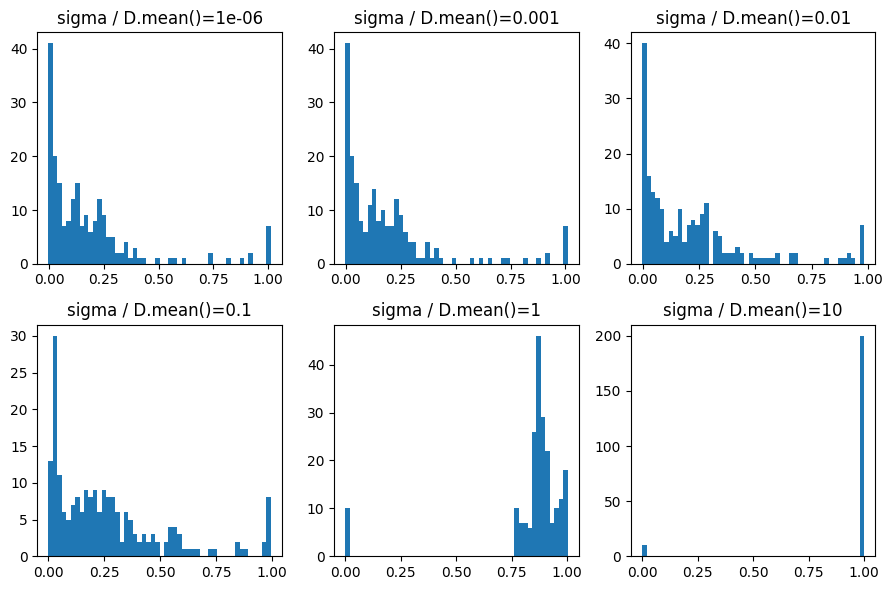

In [5]:
N_NEIGHBORS = 20

mean = dtw_matrix.mean()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
for sigma_rel, ax in zip(
    [1e-6, 1e-3, 1e-2, 1e-1, 1, 10],
    axes.flatten()
):
    weight_matrix = laplacian_score.compute_weight_matrix(
        dataset,
        n_neighbors=N_NEIGHBORS,
        sigma=sigma_rel * mean,
        precomputed_distances=dtw_matrix
    )
    lscores = laplacian_score.laplacian_score(dataset.features, weight_matrix)
    ax.hist(lscores, bins=50)
    ax.set_title(f'sigma / D.mean()={sigma_rel}')

plt.tight_layout()   
plt.show()
plt.close()

**Observations:**
- First, we observe that there is two quasi-stationary phases, one when `sigma` is really small, and one when `sigma` is really large. This is not surprising:
    - When `sigma` is really small, each point can nearly see only itself; indeed when the variance tends to zero, the gaussian distribution concentrates around zero, which mean that the values of the neighbors of one serie have nearly no importance for the computation of the Laplacian score
    - When `sigma`is really large, each neighbor of a time series have nearly the same importance, resulting in nearly the same value of the Laplacian score for every features (TODO: better interpretation).
- Thus, the values of `sigma` that will be of interest are the ones that are between those two stationary phases, i.e. for `sigma / dtw_matrix.mean()` between 0.001 and 0.1.

Now, let's have a closer look of what happen for the performance for `sigma` between $10^{-7}$ and $10^3$:

     1415208ms INFO  [datasets.py] Initiating dataset Earthquakes
     1415268ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Earthquakes
     1415272ms INFO  [datasets.py] Initiating dataset Wafer
     1415273ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
     1415275ms INFO  [datasets.py] Initiating dataset WormsTwoClass
     1415276ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
     1415432ms INFO  [datasets.py] Extracting the features of 461 time series
     1416021ms INFO  [datasets.py] Extracting the features of 2000 time series
     1416157ms INFO  [datasets.py] Extracting the features of 258 time series
     1416160ms INFO  [152699635.py] Computing the accuracy for 100 values of sigma with dataset=Earthquakes, n_features=10
     1429460ms INFO  [152699635.py] Computing the accuracy for 100 values of sigma with d

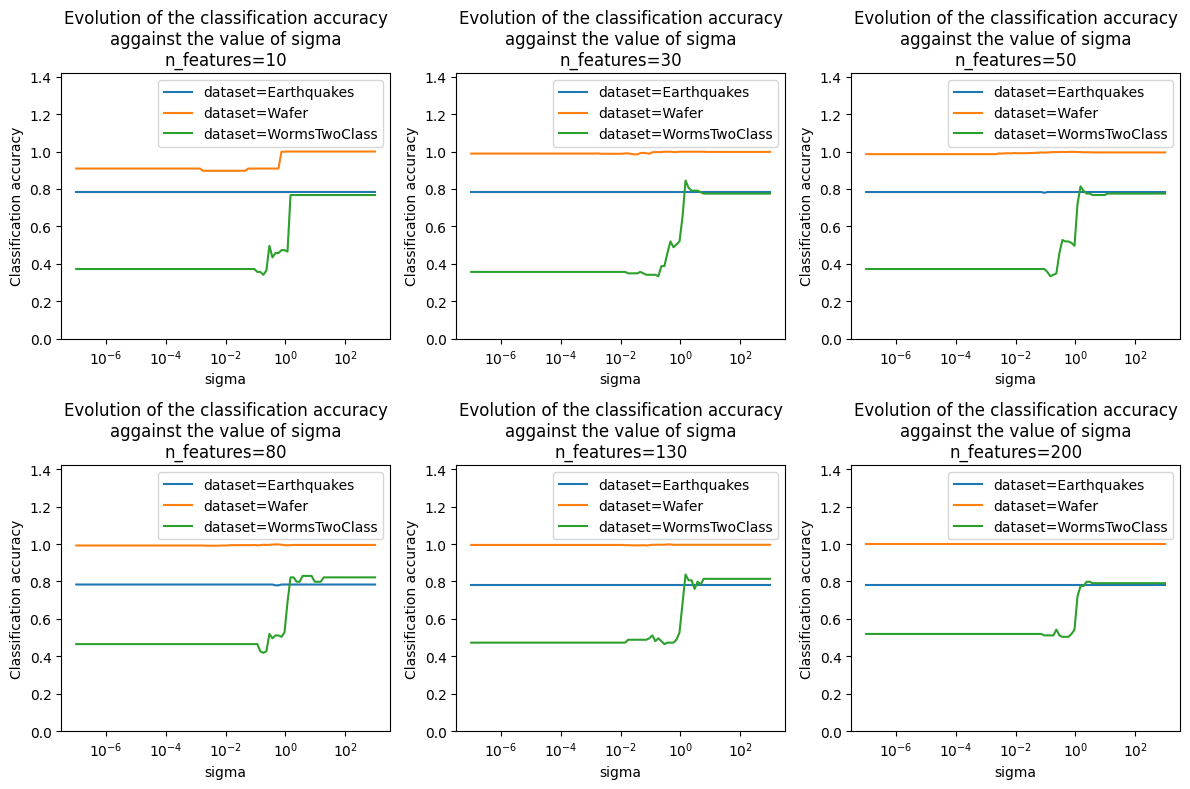

In [15]:
BASE = 10
START = -7
STOP = 3
NB_POINT = 100
N_FEATURES = 50
N_NEIGHBORS = 10
DATASETS = [
    Dataset(EARTHQUAKES),
    Dataset(WAFER),
    Dataset(WORMS),
]
N_FEATURES = [10, 30, 50, 80, 130, 200]

# Pre-loading from disk
for dataset in DATASETS:
    _ = dataset.ned_distance_matrix
    _ = dataset.dtw_distance_matrix
    _ = dataset.features

# Log space for sigma values
sigma_values = np.logspace(start=START, stop=STOP, num=NB_POINT, base=BASE)
dataset_feat_to_accuracies_list = collections.defaultdict(list)

# Computing the accuracy
for n_features in N_FEATURES:
    for dataset in DATASETS:
        logger.info(f'Computing the accuracy for {len(sigma_values)} values of sigma with dataset={dataset.name}, n_features={n_features}')
        for sigma in sigma_values:
            feature_selector = laplacian_score.LaplacianSelection(
                dataset,
                use_dtw=True,
                sigma=dataset.dtw_distance_matrix.mean() * sigma,
                n_neighbors=N_NEIGHBORS,
                n_features=n_features,
            )
            prec, recall = get_svc_accuracy(
                dataset.features.T,
                dataset.labels,
                feature_selector,
            )
            dataset_feat_to_accuracies_list[dataset.name, n_features].append(prec)

logger.info('Plotting simulations of the accuracy')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
for n_features, ax in zip(
    N_FEATURES,
    axes.flatten()
):
    for dataset in DATASETS:
        ax.plot(sigma_values, dataset_feat_to_accuracies_list[dataset.name, n_features], label=f'dataset={dataset.name}')
    ax.set_xscale('log')
    ax.set_ylim(0, 1.42)
    ax.legend()
    ax.set_xlabel('sigma')
    ax.set_ylabel('Classification accuracy')
    ax.set_title(f'Evolution of the classification accuracy\naggainst the value of sigma\nn_features={n_features}')

plt.tight_layout() 
plt.show()
plt.close()

Now, let's have a look at what happens close to $10^{-1}$, for dataset 'DiatomSizeReduction'. We observe that the smaller the number of neighbors, the more stable the method is.

In [16]:
BASE = 10
START = -2
STOP = -0
NB_POINT = 300
N_FEATURES = 80
N_NEIGHBORS = [5, 10, 20, 30]

dataset = Dataset(WORMS)

# Pre-loading from disk
_ = dataset.ned_distance_matrix
_ = dataset.dtw_distance_matrix
_ = dataset.features

# Log space for sigma values
sigma_values = np.logspace(start=START, stop=STOP, num=NB_POINT, base=BASE)
nneighbors_to_accuracies_list = collections.defaultdict(list)

# Computing the accuracy
for n_neighbors in N_NEIGHBORS:
    logger.info(f'Computing the accuracy for {len(sigma_values)} values of sigma with n_neighbors={n_neighbors}')
    for sigma in tqdm(sigma_values):
        feature_selector = laplacian_score.LaplacianSelection(
            dataset,
            use_dtw=False,
            sigma=dataset.ned_distance_matrix.mean() * sigma,
            n_neighbors=n_neighbors,
            n_features=N_FEATURES,
        )
        prec, recall = get_svc_accuracy(
            dataset.features.T,
            dataset.labels,
            feature_selector,
        )
        nneighbors_to_accuracies_list[n_neighbors].append(prec)

     2454937ms INFO  [datasets.py] Initiating dataset WormsTwoClass
     2454939ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
     2455248ms INFO  [datasets.py] Extracting the features of 258 time series
     2455269ms INFO  [710563775.py] Computing the accuracy for 300 values of sigma with n_neighbors=5


100%|██████████| 300/300 [00:17<00:00, 17.55it/s]

     2472370ms INFO  [710563775.py] Computing the accuracy for 300 values of sigma with n_neighbors=10



100%|██████████| 300/300 [00:17<00:00, 16.99it/s]

     2490032ms INFO  [710563775.py] Computing the accuracy for 300 values of sigma with n_neighbors=20



100%|██████████| 300/300 [00:16<00:00, 18.23it/s]

     2506494ms INFO  [710563775.py] Computing the accuracy for 300 values of sigma with n_neighbors=30



100%|██████████| 300/300 [00:16<00:00, 18.72it/s]


     2522584ms INFO  [1817011591.py] Plotting simulations of the accuracy


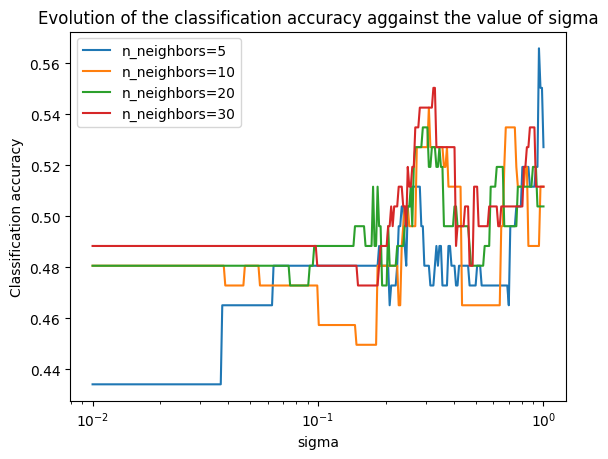

In [17]:
logger.info('Plotting simulations of the accuracy')
for n_neighbors in N_NEIGHBORS:
    plt.plot(sigma_values, nneighbors_to_accuracies_list[n_neighbors], label=f'n_neighbors={n_neighbors}')
plt.xscale('log')
plt.legend()
plt.xlabel('sigma')
plt.ylabel('Classification accuracy')
plt.title('Evolution of the classification accuracy aggainst the value of sigma')
plt.show()
plt.close()

## Influence of the number of features

     2584261ms INFO  [datasets.py] Initiating dataset WormsTwoClass
     2584263ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
     2584506ms INFO  [datasets.py] Extracting the features of 258 time series
     2584508ms INFO  [803673051.py] Computing the accuracy over the number of features


100%|██████████| 387/387 [00:45<00:00,  8.55it/s]

     2629766ms INFO  [803673051.py] Plotting simulations of the accuracy


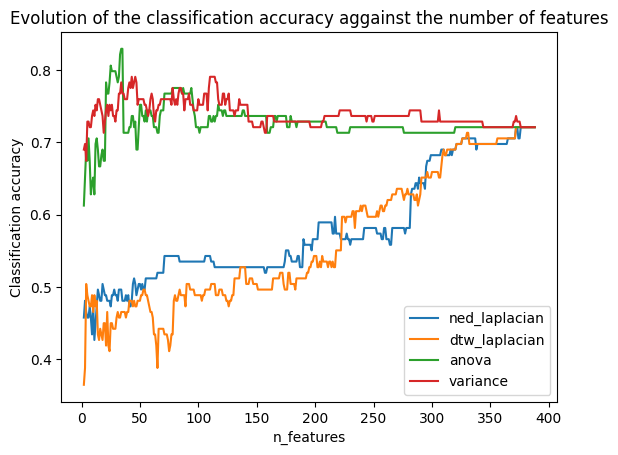

In [18]:
MAX_FEATURES = 500
SIGMA_FACTOR = 3e-1
N_NEIGHBORS = 30
SELECTOR_NAME = ['ned_laplacian', 'dtw_laplacian', 'anova', 'variance']

dataset = Dataset(WORMS)
n_features_list = list(range(2, min(dataset.features.shape[0], MAX_FEATURES)))
method_to_acc_list = collections.defaultdict(list)

# Mapping the variance to the number of features

logger.info('Computing the accuracy over the number of features')
for n_features in tqdm(n_features_list):
    
    # Building the feature selectors
    ned_laplacian_selector = laplacian_score.LaplacianSelection(
        dataset,
        use_dtw=False,
        sigma=dataset.ned_distance_matrix.mean() * SIGMA_FACTOR,
        n_neighbors=N_NEIGHBORS,
        n_features=n_features,
    )
    dtw_laplacian_selector = laplacian_score.LaplacianSelection(
        dataset,
        use_dtw=True,
        sigma=dataset.dtw_distance_matrix.mean() * SIGMA_FACTOR,
        n_neighbors=N_NEIGHBORS,
        n_features=n_features,
    )
    anova_selector = SelectKBest(f_classif, k=n_features)
    variance_selector = VarianceSelection(dataset, n_features)

    # Computing accuracy
    for selector, name in zip(
        [ned_laplacian_selector, dtw_laplacian_selector, anova_selector, variance_selector],
        SELECTOR_NAME,
    ):
        method_to_acc_list[name].append(
            get_svc_accuracy(
                dataset.features.T,
                dataset.labels,
                selector,
            )[0]
        )

logger.info('Plotting simulations of the accuracy')
for name in SELECTOR_NAME:
    plt.plot(n_features_list, method_to_acc_list[name], label=f'{name}')
plt.legend()
plt.xlabel('n_features')
plt.ylabel('Classification accuracy')
plt.title('Evolution of the classification accuracy aggainst the number of features')
plt.show()
plt.close()
